# 1. Transforming text documents into a tabulated data

## 1.1 Defining and encoding categories 

In [2]:
from pydantic import BaseModel
from enum import Enum
from openai import OpenAI
from datetime import date
from keys import *
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

In [ ]:
# Structured output based on the text

class FlightType(str, Enum):
    PASSENGER = 'passenger'
    OTHER = 'other'
    def __str__(self):
        return self.value

class EventLabel(str, Enum):
    CRASH = 'crash'
    ACCIDENT = 'accident'
    INCIDENT = 'incident'
    def __str__(self):
        return self.value

class CauseLabel(str, Enum):
    PILOT = 'pilot'
    CREW = 'crew'
    TECHNICAL_FAILURE = 'technical failure'
    WEATHER_CONDITION = 'weather condition'
    MISCOMMUNICATION = 'miscommunication'
    BIRD_STRIKE = 'bird strike'
    OTHER = 'other'
    def __str__(self):
        return self.value

class IncidentDetails(BaseModel):
    flight_type : FlightType
    passenger_probability_pct : int
    date : str
    type_of_event : EventLabel
    operating_carrier : str
    marketing_carrier : str
    registration : str
    plane_manufacturer : str
    plane_model : str
    year_of_manufacture : str
    from_airport : str
    from_airport_code : str
    from_city :str
    from_country :str
    to_airport : str
    to_airport_code : str
    to_city : str
    to_country : str
    incident_location : str
    onboard_passengers :int
    onboard_crews : int
    fatalities : int
    injuries_critical : int
    injuries_minor : int
    injuries_total : int
    cause : CauseLabel
    cause_probability_pct : int
    cause_detailed : str

message_content = """You are analyzing articles on aviation event based on the given criteria. Follow the below guideline to fill in IncidentDetails output

    flight_type : categorize whether the event involves scheduled passenger flight
    passenger_probability_pct : probability of the flight being the passenger flight, in percentages
    date : date of the event in YYYY-MM-DD format
    type_of_event : use ICAO's definition for distinguishing between incident and accident : Incident is 'an occurrence, other than an accident, associated with the operation of an aircraft, which affects or could affect the safety of operation.', and accident is 'an occurrence associated with the operation of an aircraft in which a person is fatally or seriously injured, or the aircraft sustains damage or structural failure, or the aircraft is missing or completely inaccessible.'
    operating_carrier & marketing_carrier: when operating carrier is different from marketing carrier that sells tickets. Look for keywords 'operated by' or 'operated for'. Otherwise, operating_carrier and marketing_carrier are same
    registration : registration code unique to the aircraft, if available
    plane_manufacturer : name of the plane's manufactuer, if available
    plane_model : model of the plane, if available
    year_of_manufacture : manufactured year of the plane, if available
    from_airport : official name of the departure airport, ending with "airport"
    from_airport_code : three letter code of the departure airport
    from_city : city of the departure airport
    from_country_code : alpha-3 code of country of the departure airport
    to_airport : official name of the destination airport, ending with "airport"
    to_airport_code : three letter code of the destination airport
    to_city : city of the destination airport
    to_country_code : alpha-3 code of country of the destination airport
    event_location : location of the event, if applicable
    onboard_passengers : number of onboard passengers, if available
    onboard_crews : number of onboard crews, if available
    fatalities : number of deaths, if available
    injuries_critical : number of critical injuries, if available
    injuries_minor : number of minor injuries, if available
    injuries_total : injuries_critical + injuries_minor
    cause : likely cause of the event, from the given information
    cause_probability_pct : likelihood of the stated cause in percentages
    cause_detailed : detailed cause of the event in one to two sentences"""


## 1.2 Extracting entries from the source text 

In [46]:
import os
from bs4 import BeautifulSoup, Comment
import time

client = OpenAI(api_key = ACTIVE_KEY)

dfs = []

total_processing_time = 0

for y in range(2021,2026):
    folder_path = os.path.join(os.path.os.getcwd(),'articles',str(y))
    article_list = os.listdir(folder_path)
    for a in article_list:
        article_path = os.path.join(folder_path,a)
        with open (article_path,'r', encoding='latin1') as file :
            article = file.read()
            soup = BeautifulSoup(article,'html5lib')

        # Remove unnecessary tags to reduce token input
        for tag in soup('script'):
            tag.decompose()
        for tag in soup('meta'):
            tag.decompose()
        # Remove all comments
        for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
            comment.extract()

        start = time.perf_counter()
        # Connect to OpenAI API and send the input
        response = client.beta.chat.completions.parse(
        model="gpt-4o-mini-2024-07-18",
        temperature = 0,
        store=True,
        messages=[
            {"role" : "system", "content": message_content},
            {"role" : 'user', "content" : str(soup)}
        ],
        response_format = IncidentDetails,
        )
        gpt_output = pd.DataFrame(response.choices[0].message.parsed).set_index(0).T
        end = time.perf_counter()

        total_processing_time += (end - start)

        dfs.append(gpt_output)
    print(f"Completed event categorization from {y}")

Completed event categorization from 2021
Completed event categorization from 2022
Completed event categorization from 2023
Completed event categorization from 2024
Completed event categorization from 2025


In [ ]:
df = pd.concat(dfs).head()
print(f"Total processing time for Chat GPT API usage : {round(total_processing_time / 60,1)} min, or {round(total_processing_time/df.shape[0],1)} seconds per document")

Total processing time for Chat GPT API usage : 77.8 min, or 5.3 seconds per document


In [ ]:
# 887 requests, 4980720 tokens, Total spend $ 0.8

In [54]:
df.to_csv('aviation_events.csv')

# 2. Filtering scheduled passenger flights

In [24]:
df = pd.read_csv('aviation_events.csv').iloc[:,1:]
print(df.shape)
df.head()

(887, 28)


,flight_type,passenger_probability_pct,date,type_of_event,operating_carrier,marketing_carrier,registration,plane_manufacturer,plane_model,year_of_manufacture,from_airport,from_airport_code,from_city,from_country,to_airport,to_airport_code,to_city,to_country,incident_location,onboard_passengers,onboard_crews,fatalities,injuries_critical,injuries_minor,injuries_total,cause,cause_probability_pct,cause_detailed
0,other,0,2021-03-20,accident,Trigana Air Service,Trigana Air Service,PK-YSF,Boeing,737-4Y0,1988,Jakarta-Halim Perdana Kusuma Airport,HLP,Jakarta,IDN,Makassar-Sultan Hasanuddin International Airport,UPG,Makassar,IDN,Jakarta-Halim Perdana Kusuma Airport,4,0,0,0,0,0,technical failure,80,The aircraft reported a failure of engine no.2...
1,other,0,2021-03-23,accident,SprintAir,SprintAir,SP-KPU,Saab,340AF,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gdansk-Lech Walesa Airport,0,0,0,0,0,0,other,100,The accident occurred when the pilot of a Vulc...
2,other,0,2021-07-04,accident,ELISA,ELISA,UP-A0135,Antonov,An-2R,1973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"12 km from Karaultobe, Kyzylorda",2,0,0,0,0,0,technical failure,80,The aircraft experienced an engine malfunction...
3,other,0,2021-03-26,accident,West Wind Aviation Ltd.,West Wind Aviation Ltd.,5Y-NJS,Beechcraft,B200 Super King Air,1981,Eldoret Airport,HKEL,Eldoret,KEN,Nairobi-Wilson Airport,HKNW,Nairobi,KEN,"Ngong Racecourse, Nairobi",2,1,0,0,0,0,technical failure,80,The aircraft encountered severe icing conditio...
4,other,0,2021-10-05,accident,Sierra West Airlines,Sierra West Airlines,N283SA,Dassault,Falcon 20C,1967,Lubbock Preston Smith International Airport,LBB,Lubbock,USA,Thomson-McDuffie County Airport,KHQU,Thomson,USA,"1.3 km W of Thomson-McDuffie County Airport, GA",2,0,2,0,0,0,pilot,90,The accident was caused by the flight crew's c...


<AxesSubplot:>

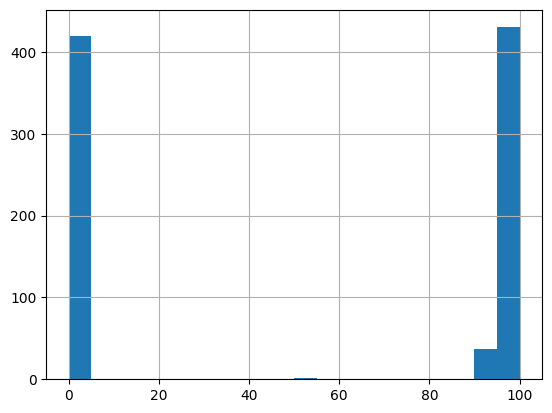

In [25]:
# Checking probability of events being categorized as "passenger" flight
df.passenger_probability_pct.hist(bins = 20)

> The histogram suggests a clear distinction between flight events involving passenger planes and those involving other types of aircraft... Except for one.

In [26]:
# What is troubling?

df.loc[(df.passenger_probability_pct <= 70) & (df.passenger_probability_pct >= 30)]

,flight_type,passenger_probability_pct,date,type_of_event,operating_carrier,marketing_carrier,registration,plane_manufacturer,plane_model,year_of_manufacture,from_airport,from_airport_code,from_city,from_country,to_airport,to_airport_code,to_city,to_country,incident_location,onboard_passengers,onboard_crews,fatalities,injuries_critical,injuries_minor,injuries_total,cause,cause_probability_pct,cause_detailed
794,other,50,2024-04-12,accident,HS Flugcharter GmbH,HS Flugcharter GmbH,N22S,Cessna,Citation M2,2014,Fort Myers-Page Field Airport,FMY,Fort Myers,USA,Montreal-St Hubert Airport,YHU,Montreal,CAN,"Montreal-St Hubert Airport, QC",1,1,0,0,0,0,technical failure,70,The pilot lost directional control during land...


> It's a chartered flight

## 2.1 Filtering out non-scheduled flights

In [27]:
passenger = df.loc[df.flight_type == 'passenger']
print(passenger.shape)
passenger.head()

(456, 28)


,flight_type,passenger_probability_pct,date,type_of_event,operating_carrier,marketing_carrier,registration,plane_manufacturer,plane_model,year_of_manufacture,from_airport,from_airport_code,from_city,from_country,to_airport,to_airport_code,to_city,to_country,incident_location,onboard_passengers,onboard_crews,fatalities,injuries_critical,injuries_minor,injuries_total,cause,cause_probability_pct,cause_detailed
15,passenger,100,2021-07-16,accident,SiLA - Siberian Light Aviation,SiLA - Siberian Light Aviation,RA-28728,Antonov,An-28,1989,Kedrovo Airport,KED,Kedrovo,RUS,Tomsk-Bogashevo Airport,TOF,Tomsk,RUS,"52 km SE of Kedrovo, Russia",19,0,0,0,0,0,crew,80,The accident was likely influenced by the crew...
20,passenger,100,2021-02-08,accident,Luxwing,Luxwing,9H-FAM,Embraer,EMB-500 Phenom 100,2011,Venice-Marco Polo Airport,VCE,Venice,ITA,Paris-Le Bourget Airport,LBG,Paris,FRA,Paris-Le Bourget Airport,3,0,0,0,0,0,technical failure,80,The aircraft stalled shortly before landing du...
21,passenger,90,2021-09-03,accident,PB Air LLC,PB Air LLC,N351CW,Raytheon,390 Premier I,2002,Indianapolis International Airport,IND,Indianapolis,USA,Naples Airport,APF,Naples,USA,"Naples Airport, FL",4,0,0,0,0,0,technical failure,80,The pilot reported that the brakes 'faded away...
23,passenger,100,2021-10-23,accident,Envoy Air,American Eagle,N252NN,Embraer,ERJ-175LR,2017,Miami International Airport,MIA,Miami,USA,Raleigh/Durham Airport,RDU,Raleigh,USA,"Miami International Airport, FL",63,2,0,1,0,1,miscommunication,90,The incident was caused by a miscommunication ...
24,passenger,100,2021-03-12,accident,Grant Aviation,Grant Aviation,N407GV,Cessna,208B Grand Caravan,1997,Chevak Airport,VAK,Chevak,USA,Bethel Airport,BET,Bethel,USA,"Chevak Airport, AK",5,0,0,0,0,0,pilot,90,The pilot lost directional control during back...


In [28]:
# Further look into carriers to make sure only schedules flights are included
passenger.marketing_carrier = passenger.marketing_carrier.astype('str')
passenger.marketing_carrier.unique()

/tmp/ipykernel_3289/59629532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passenger.marketing_carrier = passenger.marketing_carrier.astype('str')


array(['SiLA - Siberian Light Aviation', 'Luxwing', 'PB Air LLC',
       'American Eagle', 'Grant Aviation', 'Ryanair', 'American Airlines',
       'Southwest Airlines', 'SkyJet', 'Unknown', 'Air Canada',
       'Flyadeal', 'Wright Air Service', 'Delta Air Lines',
       'Frontier Airlines', 'Emirates', 'Iran Air', 'Keewatin Air',
       'United Express', 'Uni Air', 'Halsted Aviation Corporation (HAC)',
       'IndiGo Airlines', 'Vistara', 'Alaska Airlines',
       'Austrian Airlines', 'Utair', 'EHS LifeFlight Services',
       'Transwest Air', 'Condor Flugdienst', 'THY Turkish Airlines',
       'Sky Express', 'Roraima Airways', 'Air Europa Express',
       'Norwegian Air Sweden', 'Everts Air Cargo', 'Skyward Express',
       'Aeroservice', 'UN World Food Programme',
       'Mauritania Airlines International', 'Air Tindi', 'SVG Air',
       'Brasil Vida Táxi Aéreo', 'VistaJet', 'Viva Aerobus',
       'Lake Clark Air', 'Spirit Airlines', 'Air Caraïbes Atlantique',
       'United Airline

In [29]:
passenger.loc[passenger.marketing_carrier.isin(['Unknown','nan'])]

,flight_type,passenger_probability_pct,date,type_of_event,operating_carrier,marketing_carrier,registration,plane_manufacturer,plane_model,year_of_manufacture,from_airport,from_airport_code,from_city,from_country,to_airport,to_airport_code,to_city,to_country,incident_location,onboard_passengers,onboard_crews,fatalities,injuries_critical,injuries_minor,injuries_total,cause,cause_probability_pct,cause_detailed
35,passenger,100,2021-04-18,accident,Unknown,Unknown,XB-PIZ,Learjet,25B,1975,Cancún Airport,CUN,Cancún,MEX,Toluca-Licenciado Adolfo López Mateos Internat...,TLC,Toluca,MEX,Toluca-Licenciado Adolfo López Mateos Internat...,7,2,0,0,0,0,other,100,The Learjet 25B sustained substantial damage f...
217,passenger,100,2022-06-10,accident,NaN,nan,NaN,Airbus,A319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,near Düsseldorf,0,0,0,1,0,1,weather condition,80,The incident occurred during cruise flight whe...
578,passenger,90,2023-02-02,accident,Unknown,Unknown,5Y-BMZ,Cessna,208B Grand Caravan,1994,Nasir Airport,HSNA,Nasir,STP,NaN,NaN,NaN,NaN,"Nasir Airport, South Sudan",1,0,1,0,0,0,technical failure,80,The aircraft reportedly stalled during takeoff...


In [31]:
# Drop the above events as they either do not seem to be scheduled passenger flights or missing details
passenger.loc[passenger.marketing_carrier.isin(['Unknown','nan']), 'flight_type'] = 'unscheduled'

In [32]:
carrier_list = passenger.marketing_carrier.unique()
carrier_list

array(['SiLA - Siberian Light Aviation', 'Luxwing', 'PB Air LLC',
       'American Eagle', 'Grant Aviation', 'Ryanair', 'American Airlines',
       'Southwest Airlines', 'SkyJet', 'Unknown', 'Air Canada',
       'Flyadeal', 'Wright Air Service', 'Delta Air Lines',
       'Frontier Airlines', 'Emirates', 'Iran Air', 'Keewatin Air',
       'United Express', 'Uni Air', 'Halsted Aviation Corporation (HAC)',
       'IndiGo Airlines', 'Vistara', 'Alaska Airlines',
       'Austrian Airlines', 'Utair', 'EHS LifeFlight Services',
       'Transwest Air', 'Condor Flugdienst', 'THY Turkish Airlines',
       'Sky Express', 'Roraima Airways', 'Air Europa Express',
       'Norwegian Air Sweden', 'Everts Air Cargo', 'Skyward Express',
       'Aeroservice', 'UN World Food Programme',
       'Mauritania Airlines International', 'Air Tindi', 'SVG Air',
       'Brasil Vida Táxi Aéreo', 'VistaJet', 'Viva Aerobus',
       'Lake Clark Air', 'Spirit Airlines', 'Air Caraïbes Atlantique',
       'United Airline

In [11]:
client = OpenAI(api_key = TEST_KEY)

response = client.beta.chat.completions.parse(
model="gpt-4o-mini-2024-07-18",
temperature = 0,
store=True,
messages=[
    {"role" : "system", "content": """Filter scheduled commercial airlines from the list, separated by comma"""},
    {"role" : 'user', "content" : ", ".join(carrier_list)}
]
)

In [33]:
scheduled_carrier_list = response.choices[0].message.content.split(', ')
scheduled_carrier_list

['American Eagle',
 'Ryanair',
 'American Airlines',
 'Southwest Airlines',
 'SkyJet',
 'Air Canada',
 'Flyadeal',
 'Delta Air Lines',
 'Frontier Airlines',
 'Emirates',
 'Iran Air',
 'IndiGo Airlines',
 'Vistara',
 'Alaska Airlines',
 'Austrian Airlines',
 'Utair',
 'Transwest Air',
 'Condor Flugdienst',
 'THY Turkish Airlines',
 'Air Europa Express',
 'Norwegian Air Sweden',
 'Skyward Express',
 'Mauritania Airlines International',
 'Air India Express',
 'JetBlue Airways',
 'Air France',
 'Ethiopian Airlines',
 'All Nippon Airways',
 'LATAM Perú',
 'Copa Airlines',
 'TAP Air Portugal',
 'Icelandair Flugfélag Islands',
 'Japan Transocean Air',
 'Angara Airlines',
 'Jubba Airways',
 'Blue Air',
 'SunExpress',
 'Korean Air',
 'SpiceJet',
 'Finnair',
 'TAG Airlines',
 'ITA Airways',
 'SAS Scandinavian Airlines',
 'Air Arabia Maroc',
 'Air Transat',
 'Brussels Airlines',
 'LATAM Airlines Chile',
 'Garuda Indonesia',
 'WestJet',
 'Allegiant Air',
 'SkyUp Airlines',
 'Flair Airlines',
 'Cat

In [37]:
passenger.flight_type = 'unscheduled'
passenger.loc[passenger.marketing_carrier.isin(scheduled_carrier_list), 'flight_type'] = 'scheduled'
passenger.head()

/tmp/ipykernel_3289/1032638936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passenger.flight_type = 'unscheduled'


,flight_type,passenger_probability_pct,date,type_of_event,operating_carrier,marketing_carrier,registration,plane_manufacturer,plane_model,year_of_manufacture,from_airport,from_airport_code,from_city,from_country,to_airport,to_airport_code,to_city,to_country,incident_location,onboard_passengers,onboard_crews,fatalities,injuries_critical,injuries_minor,injuries_total,cause,cause_probability_pct,cause_detailed
15,unscheduled,100,2021-07-16,accident,SiLA - Siberian Light Aviation,SiLA - Siberian Light Aviation,RA-28728,Antonov,An-28,1989,Kedrovo Airport,KED,Kedrovo,RUS,Tomsk-Bogashevo Airport,TOF,Tomsk,RUS,"52 km SE of Kedrovo, Russia",19,0,0,0,0,0,crew,80,The accident was likely influenced by the crew...
20,unscheduled,100,2021-02-08,accident,Luxwing,Luxwing,9H-FAM,Embraer,EMB-500 Phenom 100,2011,Venice-Marco Polo Airport,VCE,Venice,ITA,Paris-Le Bourget Airport,LBG,Paris,FRA,Paris-Le Bourget Airport,3,0,0,0,0,0,technical failure,80,The aircraft stalled shortly before landing du...
21,unscheduled,90,2021-09-03,accident,PB Air LLC,PB Air LLC,N351CW,Raytheon,390 Premier I,2002,Indianapolis International Airport,IND,Indianapolis,USA,Naples Airport,APF,Naples,USA,"Naples Airport, FL",4,0,0,0,0,0,technical failure,80,The pilot reported that the brakes 'faded away...
23,scheduled,100,2021-10-23,accident,Envoy Air,American Eagle,N252NN,Embraer,ERJ-175LR,2017,Miami International Airport,MIA,Miami,USA,Raleigh/Durham Airport,RDU,Raleigh,USA,"Miami International Airport, FL",63,2,0,1,0,1,miscommunication,90,The incident was caused by a miscommunication ...
24,unscheduled,100,2021-03-12,accident,Grant Aviation,Grant Aviation,N407GV,Cessna,208B Grand Caravan,1997,Chevak Airport,VAK,Chevak,USA,Bethel Airport,BET,Bethel,USA,"Chevak Airport, AK",5,0,0,0,0,0,pilot,90,The pilot lost directional control during back...


In [47]:
# Check for missing values
passenger.date = pd.to_datetime(passenger.date)
passenger.loc[passenger.flight_type == 'scheduled'].isna().sum()

/tmp/ipykernel_3289/3805301887.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passenger.date = pd.to_datetime(passenger.date)


flight_type                  0
passenger_probability_pct    0
date                         0
type_of_event                0
operating_carrier            0
marketing_carrier            0
registration                 1
plane_manufacturer           0
plane_model                  1
year_of_manufacture          3
from_airport                 3
from_airport_code            3
from_city                    3
from_country                 1
to_airport                   6
to_airport_code              7
to_city                      6
to_country                   4
incident_location            0
onboard_passengers           0
onboard_crews                0
fatalities                   0
injuries_critical            0
injuries_minor               0
injuries_total               0
cause                        0
cause_probability_pct        0
cause_detailed               0
dtype: int64

> As there are not many missing values, these are to be inputted manually

In [43]:
df_upd = pd.concat([df.loc[df.flight_type == 'other'], passenger])
df_upd.head()

,flight_type,passenger_probability_pct,date,type_of_event,operating_carrier,marketing_carrier,registration,plane_manufacturer,plane_model,year_of_manufacture,from_airport,from_airport_code,from_city,from_country,to_airport,to_airport_code,to_city,to_country,incident_location,onboard_passengers,onboard_crews,fatalities,injuries_critical,injuries_minor,injuries_total,cause,cause_probability_pct,cause_detailed
0,other,0,2021-03-20,accident,Trigana Air Service,Trigana Air Service,PK-YSF,Boeing,737-4Y0,1988,Jakarta-Halim Perdana Kusuma Airport,HLP,Jakarta,IDN,Makassar-Sultan Hasanuddin International Airport,UPG,Makassar,IDN,Jakarta-Halim Perdana Kusuma Airport,4,0,0,0,0,0,technical failure,80,The aircraft reported a failure of engine no.2...
1,other,0,2021-03-23,accident,SprintAir,SprintAir,SP-KPU,Saab,340AF,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gdansk-Lech Walesa Airport,0,0,0,0,0,0,other,100,The accident occurred when the pilot of a Vulc...
2,other,0,2021-07-04,accident,ELISA,ELISA,UP-A0135,Antonov,An-2R,1973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"12 km from Karaultobe, Kyzylorda",2,0,0,0,0,0,technical failure,80,The aircraft experienced an engine malfunction...
3,other,0,2021-03-26,accident,West Wind Aviation Ltd.,West Wind Aviation Ltd.,5Y-NJS,Beechcraft,B200 Super King Air,1981,Eldoret Airport,HKEL,Eldoret,KEN,Nairobi-Wilson Airport,HKNW,Nairobi,KEN,"Ngong Racecourse, Nairobi",2,1,0,0,0,0,technical failure,80,The aircraft encountered severe icing conditio...
4,other,0,2021-10-05,accident,Sierra West Airlines,Sierra West Airlines,N283SA,Dassault,Falcon 20C,1967,Lubbock Preston Smith International Airport,LBB,Lubbock,USA,Thomson-McDuffie County Airport,KHQU,Thomson,USA,"1.3 km W of Thomson-McDuffie County Airport, GA",2,0,2,0,0,0,pilot,90,The accident was caused by the flight crew's c...


In [48]:
df_upd.to_csv('aviation_incidents_updated.csv', index = False)

# 3. Analysis on Tableau